```
Copyright (c) 2024-2025 National Institute of Advanced Industrial Science and Technology (AIST)
All rights reserved.
This software is released under the MIT License.
http://opensource.org/licenses/mit-license.php
```

## Introduction
In this notebook you will learn the basic use of the timestamp recorder.

1. [Records the transmitted and received timestamps of a 1 output, 1 input configuration](#1.-Records-the-transmitted-and-received-timestamps-of-a-1-output,-1-input-configuration)
   1. [Make initial settings](#1-A.-Make-initial-settings)
   2. [Set up the AXIS Switch](#1-B.-Set-up-the-AXIS-Switch)
   4. [Set up the ethernet frame capture](#1-C.-Set-up-the-ethernet-frame-capture)
   5. [Prepare send frames](#1-D.-Prepare-send-frames)
   6. [Send the frames from Port0 to Port1, in repeat mode](#1-E.-Send-the-frames-from-Port0-to-Port1,-in-repeat-mode)
   7. [Transfer the recorded timestamps to the host computer](#1-F.-Transfer-the-recorded-timestamps-to-the-host-computer)
   8. [Check the recorded timestamps](#1-G.-Check-the-recorded-timestamps)
   9. [Evaluate latency and throughput](#1-H.-Evaluate-latency-and-throughput)
   10. [Add offset to timestamps](#1-I.-Add-offset-to-timestamps)

In [1]:
import argparse
import tsn_efcc
import pyxsdb
import sys
from IPython.display import Image, display

FREQ_MHZ = 125.0

## 1. Records the transmitted and received timestamps of a 1 output, 1 input configuration
Connect TSN-EFCC ports 0 (MAC0) and 1 (MAC1) with an Ethernet cable.  
Alternatively, connect ports 0 (MAC0) and 1 (MAC1) to a network switch.

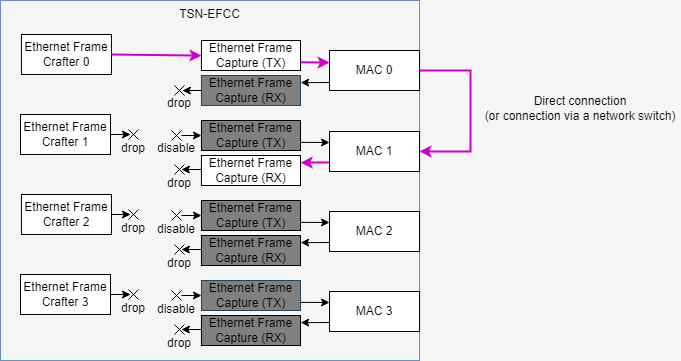

In [2]:
display(Image(filename='img/overwiew_sample_design-1g_example_configuration2.drawio.png', embed=True))

### 1-A. Make initial settings

Set JTAG2AXI target. As default, this target is expected to be target 3.  
If you want to different target value, change the next value.

In [3]:
xsdb_target = 3

In [4]:
# Open xsdb device to access TSN-EFCC
xsdb = pyxsdb.PyXsdb()
xsdb.connect()
xsdb.target(xsdb_target)

# Get the default address table object
default_addr_table = tsn_efcc.default_tsn_efcc_address_table()
print(f'{default_addr_table}\n')

# Initialize AxisNetSwitch object
switch = tsn_efcc.AxisNetSwitch(xsdb, xsdb_target, default_addr_table)

# Initialize the ef_crafter
crafter = tsn_efcc.EFCrafter(xsdb, xsdb_target, default_addr_table)

# Just to be sure, stop ef_crafter
crafter.reset(0xff)

xsdb server launched.
TsnEfccAddressTable(ef_crafter=1593835520, ef_crafter_buffers=(1342177280, 1358954496, 1375731712, 1392508928), ef_crafter_ip_tables=(1409286144, 1426063360, 1442840576, 1459617792), ef_crafter_mac_tables=(1476395008, 1493172224, 1509949440, 1526726656), ef_capture_tx_ctrl=(1325400064, 1325465600, 1325531136, 1325596672), ef_capture_rx_ctrl=(1325662208, 1325727744, 1325793280, 1325858816), ef_capture_buffers=(1073741824, 1090519040, 1107296256, 1124073472), ef_capture_buffer_switch=(1326448640, 1326514176, 1326579712, 1326645248), axis_net_switch=1610612736, commit_hash=1048576)



### 1-B. Set up the AXIS Switch

In this test, we connect EFCrafter0(port 4) to TX0(port 0).  
In addition, EFCrafter1 (port 5) is connected to TX1 (port 1) for FDB learning when using a switch.  
Other input ports are disconnected from output port.

In [5]:
switch.start_config()
switch.connect(4, 0)   # generator0 -> MAC0 TX
                       # loopback by ethernet cable: MAC 0 TX -> MAC1 RX, MAC1 TX -> MAC0 RX
switch.connect(5, 1)   # generator1 -> MAC1 TX
switch.commit()

# show current switch status
switch.show_configuration()

input MAC0-RX -> Drop
input MAC1-RX -> Drop
input MAC2-RX -> Drop
input MAC3-RX -> Drop
input EFCrafter0 -> MAC0-TX
input EFCrafter1 -> MAC1-TX
input EFCrafter2 -> Drop
input EFCrafter3 -> Drop


### 1-C. Set up the ethernet frame capture

Configure recorder (1 TX, 1 RX)

In [6]:
recorder0 = tsn_efcc.EFCapture(xsdb, xsdb_target, default_addr_table, 0)
recorder1 = tsn_efcc.EFCapture(xsdb, xsdb_target, default_addr_table, 1)
recorder0.select_port('tx')    # use recorder of MAC 0 to record TX timestamp
recorder1.select_port('rx')    # use recorder of MAC 1 to record RX timestamp

# Just to be sure, let's reset the timestamp recording status
recorder0.reset()
recorder1.reset()

### 1-D. Prepare send frames

Create a frame for the flow from port 0 to port 1 and push the frame object to EFCrafter.

In [7]:
frame0 = tsn_efcc.Frame('Frame0').ether(dst=2, src=1).ipv4(dst=2, src=1).udp(dst=2000, src=1000).payload(length=1024)

eol_frame = tsn_efcc.Frame.eol()
crafter.set_frame(port=0, index=0, frame=frame0)
crafter.set_frame(port=0, index=1, frame=eol_frame)

# Dump the frame information pushed to EFCrafter
for frame in crafter.get_frames(port=0):
    print(frame)

Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
EOL()


We will create and send a reverse frame for FDB learning.

In [8]:
frame1 = tsn_efcc.Frame('Frame1').ether(dst=1, src=2).ipv4(dst=1, src=2).udp(dst=2000, src=1000).payload(length=1024)

crafter.set_frame(port=1, index=0, frame=frame1)
crafter.set_frame(port=1, index=1, frame=eol_frame)

# Dump the frame information pushed to EFCrafter
for frame in crafter.get_frames(port=1):
    print(frame)

# Send the frame from Port1 to Port0
port1 = 1
bit_mask = 1 << port1
crafter.reset(bit_mask)
crafter.start(bit_mask)

# Wait for transmission to complete
crafter.wait(port1)

Frame0000.ETHER(dst=1, src=2).IPV4(dst=1, src=2).UDP(dst=2000, src=1000).Payload(length=1024)
EOL()


### 1-E. Send the frames from Port0 to Port1, in repeat mode

In [9]:
port0 = 0
bit_mask = 1 << port0
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)

print('Wait until 1000 frames are sent')
crafter.wait_until(port0, 1000)

# Reset ef_crafter to stop repeating
crafter.reset(0xff)

Wait until 1000 frames are sent


### 1-F. Transfer the recorded timestamps to the host computer

Check whether TimestampStatistics records 1000 timestamps or not.

In [10]:
recorder0.wait(1000)
recorder1.wait(1000)

1000

At least 1000 frames are recorder. Current status of EFCapture is

In [11]:
print('-------------')
print('Recorder0: ')
for k, v in recorder0.get_status().items():
    print(f'  {k}: {v}')
print('Recorder1: ')
for k, v in recorder1.get_status().items():
    print(f'  {k}: {v}')
print('-------------')

-------------
Recorder0: 
  status: Recording timestamps
  bramcounter: 1271
  framecounter: 1271
Recorder1: 
  status: Recording timestamps
  bramcounter: 1271
  framecounter: 1271
-------------


Read 1000 frames from hardware.

In [12]:
send_stat = recorder0.read_timestamp(1000)
recv_stat = recorder1.read_timestamp(1000)

read_timestamp: |██████████████████████████████| 1000 / 1000
read_timestamp: |██████████████████████████████| 1000 / 1000


### 1-G. Check the recorded timestamps

The stat object contains a list of timestamps. The first 5 timestamps are

In [13]:
print('Timestamp(Port0):')
for k, v in list(send_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp={v}')
print('Timestamp(Port1):')
for k, v in list(recv_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp={v}')

Timestamp(Port0):
  id=0, timestamp=2797740495
  id=1, timestamp=2797741585
  id=2, timestamp=2797742675
  id=3, timestamp=2797743765
  id=4, timestamp=2797744855
Timestamp(Port1):
  id=0, timestamp=2797740686
  id=1, timestamp=2797741777
  id=2, timestamp=2797742867
  id=3, timestamp=2797743957
  id=4, timestamp=2797745047


- The `id` is a number embedded in each frame by the EFCrafter. The EFCapture records the `id` read from the frame as it is in the stat object.
  - The upper 3 bits of the 32 bit `id` indicate the EFCrafter number. In this case EFCrafter 0 is used, so the upper 3 bits are 0.
  - The remaining 29 bits of the 32-bit `id` are the frame number, which indicates how many frames the ef_crafter has processed. However, the counter value is also incremented when the ef_crafter processes an NOP frame, so it does not necessarily correspond to the number of output frames.
- The `timestamp` is the time at which the first byte of the frame passed through the EFCapture. The unit is cycles, and because this design is operating at a clock frequency of 125 MHz, the value is multiplied by 8 to give ns.
- The stat object is an object that holds the received timestamps, and provides various functions such as latency measurement between timestamps and throughput measurement. This will be explained in the next section.

To save timestamps, call `save_to_csv()` function.

In [14]:
send_stat.save_to_csv("2_send.csv")
recv_stat.save_to_csv("2_recv.csv")

### 1-H. Evaluate latency and throughput

The latency from send to recv can be calculated by taking the difference between the two timestamps.  
The timestamp difference can be obtained using the `subtract()` function.  
Subtract function calculates the difference between timestamps with the same `id` and discards timestamps that only exist in either send_stat or recv_stat.

In [15]:
diff_stat = recv_stat.subtract(send_stat)

The first 5 timestamp differences are

In [16]:
print('Timestamp difference(Port0 -> Port1):')
for k, v in list(diff_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp_diff={v}')

Timestamp difference(Port0 -> Port1):
  id=0, timestamp_diff=191
  id=1, timestamp_diff=192
  id=2, timestamp_diff=192
  id=3, timestamp_diff=192
  id=4, timestamp_diff=192


The `timestamp_diff` is the timestamp difference expressed in cycles.

To save the timestamp difference, you can also call `save_to_csv()` function.

In [17]:
diff_stat.save_to_csv("2_diff.csv")

To show the latency statistics, call `summary()` function.  
It is also possible to output to a file by changing the `f=sys.stdout` part to an io object.  
Example: 
```
with open('diff_summary.txt', 'w') as f:
    diff_stat.summary(freq_mhz=FREQ_MHZ, name='Latency', f=f)
```

In [18]:
diff_stat.summary(freq_mhz=FREQ_MHZ, name='Latency', f=sys.stdout)

--------------------------------
TimestampStat(Latency): id range = [0x00000000:0x000003e7]
Minimum Timestamp: 1528.00 ns
Maximum Timestamp: 1552.00 ns
Average Timestamp: 1540.26 ns
Stddev Timestamp: 4.02 ns


Next, compute bandwidth of each port.  

Bandwidth is calculated by dividing the total number of bytes of frames entering a section by the time of that section.  
The `summary_bandwidth()` function calculates the total number of bytes from the number of frames received and the frame size, and the time period from the timestamp of the first frame in send_stat and the timestamp of the last frame in recv_stat. It then calculates the bandwidth for each send and receive.  
It also returns the drop rate, which is the ratio of the number of `id` values in send_stat that are not included in recv_stat.

We need frame size information to compute bandwidth, compute by frame0 object, and add function to map `id` to frame size.  
Then call `summary_bandwidth()` function.

In [19]:
l2_size, l7_size = frame0.get_length()
print(f'l2 size of Frame0: {l2_size}, l7 size of Frame0: {l7_size}')
def timestamp_to_size(tid: int) -> int:
    return l2_size

start_timestamp = min(send_stat.get_timestamps())
end_timestamp = max(send_stat.get_timestamps())
duration_sec = (end_timestamp - start_timestamp) / (FREQ_MHZ * 1000 * 1000)

tsn_efcc.TimestampStatistic.summary_bandwidth(send_stat, recv_stat, FREQ_MHZ, timestamp_to_size, duration_sec=duration_sec, f=sys.stdout)

l2 size of Frame0: 1070, l7 size of Frame0: 1024
--------------------------------
TimestampStat(): id range = [0x00000000:0x000003e7]
# of sent frames: 1000
send rate: 982.634 Mbps
# of recvd frames: 1000
recv rate: 982.634 Mbps
# of dropped frames: 0
drop rate: 0.000 %


### 1-I. Add offset to timestamps

Next we will see how to compensate for incorrect latency correction values in the efcc.  

The original values of the TX and RX timestamps acquired by the efcc include the MAC and PHY delays of the efcc itself, as well as the delay of the cable used. However, to measure only the latency generated within the device under test, the efcc records the timestamps after subtracting these values in a correction process.  
When delay correction is performed correctly, the delay when looping back the efcc via the cable averages at less than 1 cycle.  
However, when long or extremely short cables are used, an error of one cycle or more may occur.  
In such cases, additional correction processing is required.

Suppose the average latency during cable loopback is `10 cycles`.  
Under this condition, the correct latency is the difference between the TX and RX timestamps obtained from the efcc minus 10 cycles.  
Let's add `-10` cycles to the latency obtained by 1-H.

In [20]:
new_diff_stat = diff_stat.add_constant(-10)

Check that the latency is correctly offset.

In [21]:
print('Timestamp difference(Port0 -> Port1) with offset:')
for k, v in list(new_diff_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp_diff={v}')

print('Timestamp difference(Port0 -> Port0) without offset:')
for k, v in list(diff_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp_diff={v}')

Timestamp difference(Port0 -> Port1) with offset:
  id=0, timestamp_diff=181
  id=1, timestamp_diff=182
  id=2, timestamp_diff=182
  id=3, timestamp_diff=182
  id=4, timestamp_diff=182
Timestamp difference(Port0 -> Port0) without offset:
  id=0, timestamp_diff=191
  id=1, timestamp_diff=192
  id=2, timestamp_diff=192
  id=3, timestamp_diff=192
  id=4, timestamp_diff=192
